In [1]:
%load_ext autoreload
%autoreload 2
import jupyter_black

jupyter_black.load(line_length=79)

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict

import src.alpha_queue_reactive as aqr
from src.qr_params import QRParams

### Initialising Parameters

In [3]:
# This is a small utility that I use to load my files
# I precompute some relevant quantities in and estimations
# folder that I aggregate over a date range of my choice to
# get QR statistics estimations. This class helps me do that
# My estimation files are very close to what your research/run/ferrari/alpha.py
# script outputs if I am not mistaken.
loader: QRParams = QRParams(data_dir="data/QR/v1")

ticker = "AAL"
intensities = loader.compute_intensity(
    ticker, max_spread=1
)  # If I don't specify a date range it takes everything
probabilities = loader.compute_probability(ticker, max_spread=1)
normalised_queue_sizes = loader.compute_inv_distribution(ticker)

# Here it's important to use two distinct rngs for the model and the lob
# since numpy generators are stateful.
model_rng: np.random.Generator = np.random.default_rng(1337)
lob_rng: np.random.Generator = np.random.default_rng(42)

qr_model = aqr.queue_reactive.init_fixed_size_qr(
    intensities=intensities,
    probabilities=probabilities,
    max_spread=1,
    rng=model_rng,
)
inv_distributions = aqr.utils.compute_inv_distributions(
    normalised_queue_sizes, lob_rng
)

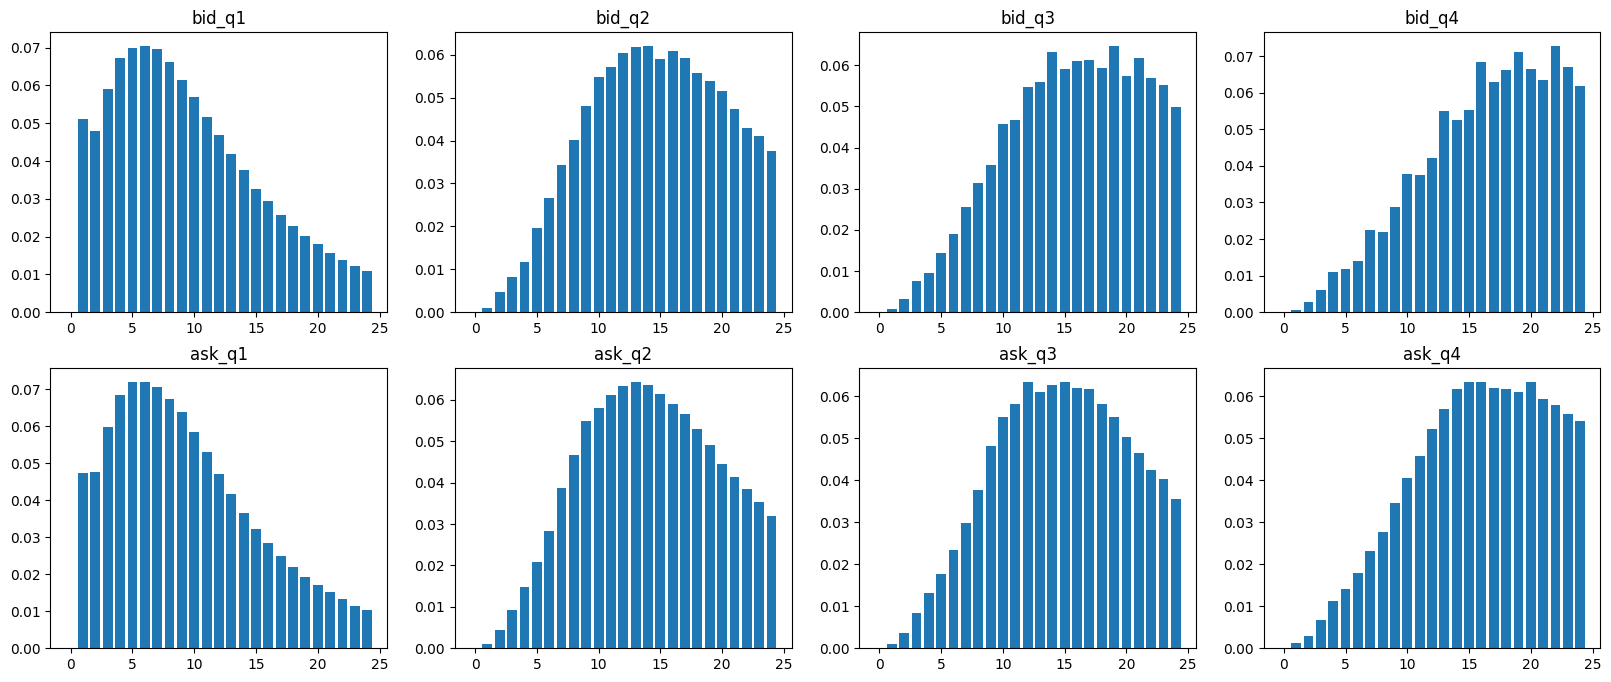

In [4]:
# I chose to keep track of the first 4 price levels of the order book
# I also clip the invariant distribution of each queue to a max size of 25
# in order to have reasonable values
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axs = axs.ravel()
queues = [
    *[(f"bid_q{i}", -i) for i in range(1, 5)],
    *[(f"ask_q{i}", i) for i in range(1, 5)],
]
for ax, (queue, queue_nbr) in zip(axs, queues):
    ax.bar(np.arange(25), inv_distributions[queue_nbr].probabilities)
    ax.set_title(queue)

plt.show()

In [5]:
# I created a little utility to parse json configs for SLURM jobs at first but
# find it actually handy
config = {
    "ticker": "AAL",
    "alpha": "imbalance",
    "matching_engine": {
        "l1": 911 + 271 + 665,
        "l2": 919 + 911,
        "delta": 30000,  # I take delta to be constant 30 microseconds here
        "gamma": 0.2,  # Here the parameter is a quantile level, gamma is
        # taken as the distribution of delta_t | delta_t < quantile(delta_t) basically
    },
    "race_model": {
        "type": "simple_race",
        "params": {
            "theta_N": 0.4,  # N orders are sampled in the simple race from a geometric distribution of this parameter
            "theta_p": 0.3,  # This is the probability a race happens when the alpha is above the threshold
            "alpha_threshold": 0.7,
            "max_spread": 1,  # Races are only triggered when the spread is leq than max_spread
        },
    },
    "trader": {
        "trader_id": 1,
        "max_spread": 1,  # The trader will not send any orders for spreads beyond this
        "max_volume": 1,  # The trader will always send trades of this size, he might be fully or partially filled
        "alpha_threshold": 0.7,
        "probability_": 0.25,  # Probability he trades when the alpha is above the threshold
    },
}

aqr_params = {
    "qr_model": qr_model,
    **aqr.config.parse_config(config, loader, model_rng),
    "rng": model_rng,
}

aqr_model = aqr.alpha_qr.AQR(**aqr_params)

In [6]:
lob_params = dict(
    bid=SortedDict({997: 5, 998: 0, 999: 2, 1000: 3}),
    ask=SortedDict({1002: 5, 1003: 7, 1004: 0, 1005: 2}),
    inv_distributions=inv_distributions,
)

lob = aqr.orderbook.LimitOrderBook(**lob_params)

In [7]:
buffer = aqr.buffer.Buffer()
aqr_model.sample(
    lob, max_ts=int(1e9 * 3600 * 5.5), buffer=buffer
)  # 5.5 hours of trading

In [8]:
df = buffer.to_df()

In [15]:
# Order book related column like P_{i} and Q_{i} either have _event or _recv
# _event means that it's the order book state from which the event originated
# and _recv is the state when the order was received by market participants.
# Imbalance spread and alpha values are recorded when the event is sent not received
# Alpha here is redundant since it's the imbalance
df.head()

ts,xt,dt,imbalance,spread,alpha,side,price,size,event,partial,rejected,race,trader_id,P_-4_event,P_-3_event,P_-2_event,P_-1_event,Q_-4_event,Q_-3_event,Q_-2_event,Q_-1_event,Q_1_event,Q_2_event,Q_3_event,Q_4_event,P_1_event,P_2_event,P_3_event,P_4_event,P_-4_recv,P_-3_recv,P_-2_recv,P_-1_recv,Q_-4_recv,Q_-3_recv,Q_-2_recv,Q_-1_recv,Q_1_recv,Q_2_recv,Q_3_recv,Q_4_recv,P_1_recv,P_2_recv,P_3_recv,P_4_recv
i64,i64,i64,f64,i64,f64,i64,i64,i64,str,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
20517701,20519548,20551378,-0.25,2,-0.25,-1,1001,1,"""Create_Bid""",false,false,false,0,997,998,999,1000,5,0,2,3,5,7,0,2,1002,1003,1004,1005,997,998,999,1000,5,0,2,3,5,7,0,2,1002,1003,1004,1005
279179509,279181356,279213186,-0.666667,1,-0.666667,1,1002,1,"""Cancel""",false,false,false,0,998,999,1000,1001,0,2,3,1,5,7,0,2,1002,1003,1004,1005,998,999,1000,1001,0,2,3,1,5,7,0,2,1002,1003,1004,1005
1373213468,1373215315,1373247145,-0.6,1,-0.6,1,1002,1,"""Cancel""",false,false,false,0,998,999,1000,1001,0,2,3,1,4,7,0,2,1002,1003,1004,1005,998,999,1000,1001,0,2,3,1,4,7,0,2,1002,1003,1004,1005
1911130626,1911132473,1911164303,-0.5,1,-0.5,1,1002,1,"""Add""",false,false,false,0,998,999,1000,1001,0,2,3,1,3,7,0,2,1002,1003,1004,1005,998,999,1000,1001,0,2,3,1,3,7,0,2,1002,1003,1004,1005
1936340983,1936342830,1936374660,-0.6,1,-0.6,1,1002,1,"""Cancel""",false,false,false,0,998,999,1000,1001,0,2,3,1,4,7,0,2,1002,1003,1004,1005,998,999,1000,1001,0,2,3,1,4,7,0,2,1002,1003,1004,1005


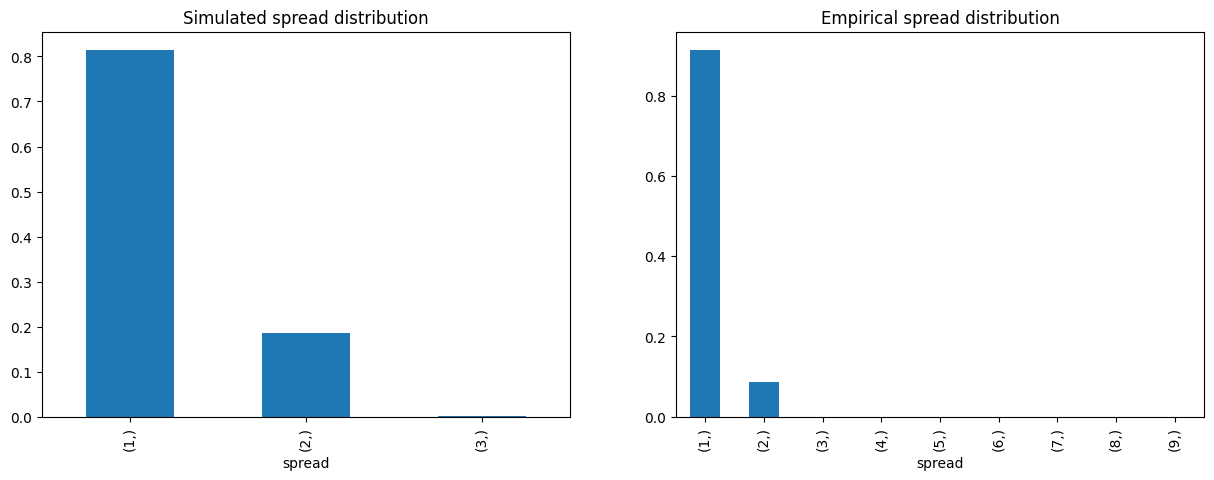

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.select(
    pl.col("spread").filter(~pl.col("rejected"))
).to_pandas().value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=ax1
)

loader.load_raw_files(ticker=ticker).select(
    "spread"
).collect().to_pandas().value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=ax2
)

ax1.set_title("Simulated spread distribution")
ax2.set_title("Empirical spread distribution")
plt.show()

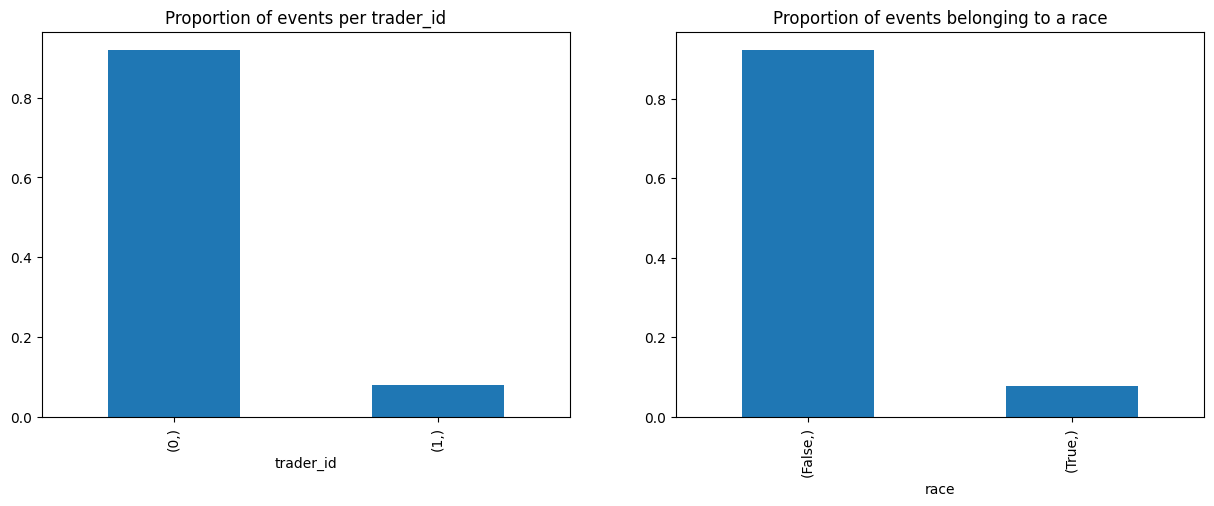

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df.select(
    pl.col("trader_id").filter(~pl.col("rejected"))
).to_pandas().value_counts(normalize=True).plot(kind="bar", ax=ax1)

df.filter(pl.col("rejected").eq(False)).select(
    "race"
).to_pandas().value_counts(normalize=True).plot(kind="bar", ax=ax2)

ax1.set_title("Proportion of events per trader_id")
ax2.set_title("Proportion of events belonging to a race")
plt.show()

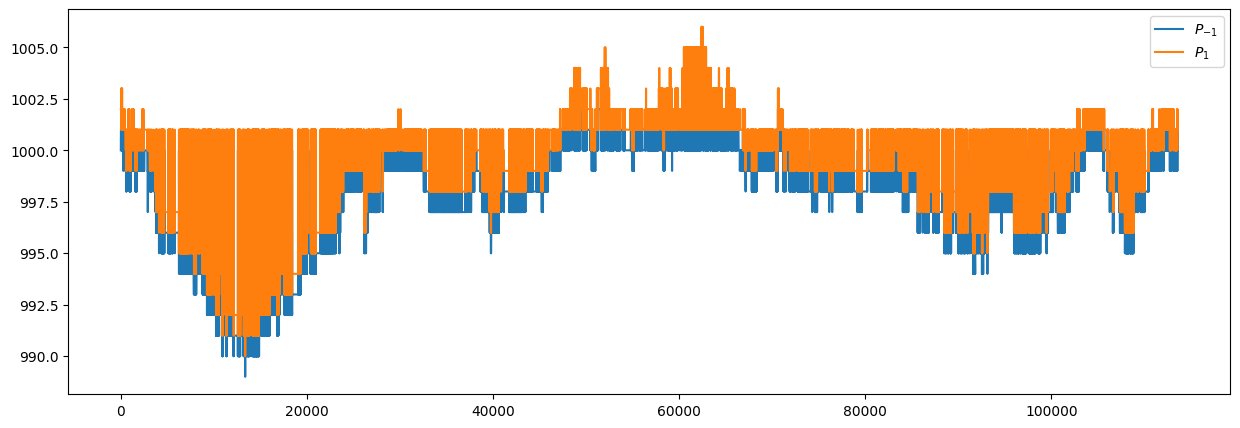

In [34]:
# Pirces is kinda weird since I added the spread constraint
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(pl.col("P_-1_event").filter(~pl.col("rejected"))),
    label=r"$P_{-1}$",
)
plt.plot(
    df.select(pl.col("P_1_event").filter(~pl.col("rejected"))), label=r"$P_1$"
)

plt.legend()
plt.show()

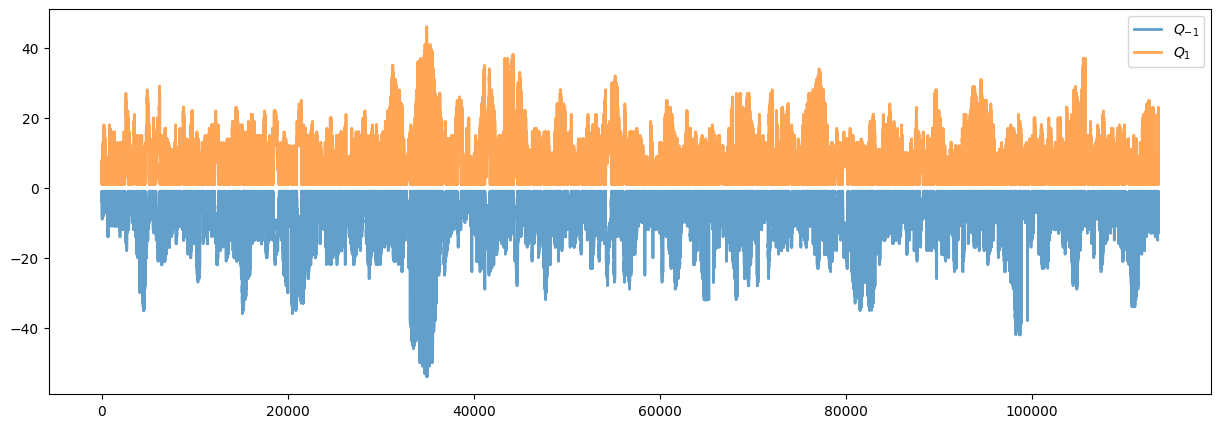

In [36]:
# Queue sizes appear to be reasonable 
plt.figure(figsize=(15, 5))

plt.plot(
    df.select(-pl.col("Q_-1_event").filter(~pl.col("rejected"))),
    label=r"$Q_{-1}$",
    lw=2,
    alpha=0.7,
)
plt.plot(
    df.select(pl.col("Q_1_event").filter(~pl.col("rejected"))),
    label=r"$Q_1$",
    lw=2,
    alpha=0.7,
)

plt.legend()
plt.show()

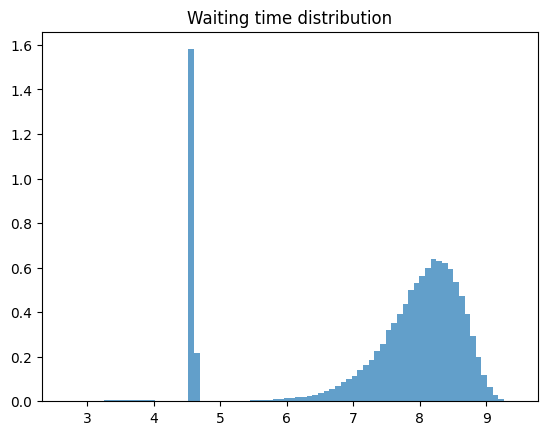

In [26]:
plt.hist(
    df.select(
        pl.col("dt").filter(~pl.col("rejected")).diff().drop_nulls().log10()
    ),
    bins=80,
    alpha=0.7,
    density=True,
)

plt.title("Waiting time distribution")
plt.show()